**Question 1 – Programming (80 points):**
In this programming problem, you will get familiar with building a neural network using
backpropagation. You will write a program that learns how to recognize the handwritten digits using
stochastic gradient descent and the MNIST training data.
The MNIST database (Modified National Institute of Standards and Technology database is a large
database of handwritten digits that is commonly used for training various image processing systems



**Step 1 Data Acquisition and Visualization (10 pts):**


In this step, you need to:
(a) Download the “MNIST” dataset and extract the files. You will get four files with extension .gz

(e.g., train-images-idx3-ubyte.gz). You can use the provided function read_idx below to read in
the dataset. As its official description, the dataset is split into 60000 training images and 10000
images. The four file corresponds to the training images, training labels, testing images and
testing labels. You need to print out their shape to finish this step. (5 pts)

In [3]:
import gzip
import struct
import numpy as np

def read_idx(filename):
    with gzip.open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)


In [4]:

# File paths for the dataset
train_images_path = 'data/train-images-idx3-ubyte.gz'
train_labels_path = 'data/train-labels-idx1-ubyte.gz'
test_images_path = 'data/t10k-images-idx3-ubyte.gz'
test_labels_path = 'data/t10k-labels-idx1-ubyte.gz'

# Read the dataset files
train_images = read_idx(train_images_path)
train_labels = read_idx(train_labels_path)
test_images = read_idx(test_images_path)
test_labels = read_idx(test_labels_path)

# Reshape and print the shapes of the datasets
print("Training Images Shape:", train_images.shape)
print("Training Labels Shape:", train_labels.shape)
print("Test Images Shape:", test_images.shape)
print("Test Labels Shape:", test_labels.shape)


Training Images Shape: (60000, 28, 28)
Training Labels Shape: (60000,)
Test Images Shape: (10000, 28, 28)
Test Labels Shape: (10000,)


B) To further understand what the dataset is, you need to use the ‘matplotlib’ library to print out a 
random data with code plt.imshow together with its label.(5 pts) You will see something like 
this:

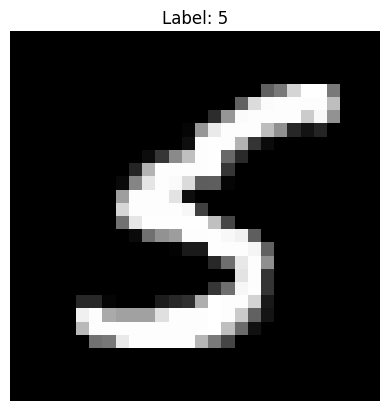

In [5]:
import matplotlib.pyplot as plt
import random

# Get a random index to select a random image and its label
random_index = random.randint(0, len(train_images))

# Select the image and its label
random_image = train_images[random_index]
random_label = train_labels[random_index]

# Reshape the image into a 28x28 format (assuming it's the MNIST image size)
random_image = random_image.reshape(28, 28)

# Plot the image using plt.imshow
plt.imshow(random_image, cmap='gray')
plt.title(f'Label: {random_label}')
plt.axis('off')  # Turn off axis
plt.show()


**Step 2 Data Preprocessing (10 pts):**

In this step, you need to: 

(a)  Normalize the pixel values of images to be between 0 and 1. (5 pts) 


In [6]:
# Normalize the pixel values of images to be between 0 and 1
train_images_normalized = train_images / 255.0



(b)  Convert the labels from categorical data into numerical values using one-hot encoding. (5 pts) 

hint: you can explore the eye function in Numpy.

In [7]:
# Convert labels to one-hot encoding
def one_hot_encode(labels, num_classes):
    num_labels = len(labels)
    index_offset = np.arange(num_labels) * num_classes
    one_hot_encoded = np.zeros((num_labels, num_classes))
    one_hot_encoded.flat[index_offset + labels.ravel()] = 1
    return one_hot_encoded


In [8]:

num_classes = 10  # As there are 10 classes (0 to 9 for digits)
train_labels_one_hot = one_hot_encode(train_labels, num_classes)


**Step 3 Network Initialization (10 pts):**

We will work with a neuron network with two hidden layers, using Sigmoid function as the activation functions for hidden 
layers and softmax activation function for the output layer. To finish this, you need to:
 
(a)  Identify the auxiliary input including the Sigmoid function and its derivative and Softmax 


In [9]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

def softmax(x):
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))  # for numerical stability
    return e_x / e_x.sum(axis=-1, keepdims=True)


In [10]:
np.random.seed(695)  # Setting the seed for reproducibility

input_size = 784
hidden_size1 = 128
hidden_size2 = 64
output_size = 10

# Initialize weights and biases for the neural network
weights_input_hidden1 = np.random.uniform(-0.1, 0.1, size=(input_size, hidden_size1))
biases_hidden1 = np.zeros(hidden_size1)

weights_hidden1_hidden2 = np.random.uniform(-0.1, 0.1, size=(hidden_size1, hidden_size2))
biases_hidden2 = np.zeros(hidden_size2)

weights_hidden2_output = np.random.uniform(-0.1, 0.1, size=(hidden_size2, output_size))
biases_output = np.zeros(output_size)


**Step 4 Feed Forward (10 pts): In this step, you need to:**

(a)  Define a function named feed_forward. Given an input x, it should output the sigmoid of wx+b 
where w and b indicates the weights and bias defined in step 2. (5 pts)

In [11]:
def feed_forward(x, weights, biases):
    layer_input = x
    for i in range(len(weights)):
        layer_output = np.dot(layer_input, weights[i]) + biases[i]
        layer_input = sigmoid(layer_output)  # Using the sigmoid activation function
    return layer_input


**Step 5 Back Propagation (15 pts): In this step, you need to implement the back 
propagation:**


(a)  You need to compute the loss for the output layer first. Here, we use categorical cross entropy 
loss function given below for multi-class classification problem. (5 pts) Note, to achieve this, you 
need to first encode the categorical labels as numerical values using one-hot encoding finished 
in step 2. (5 pts)


In [12]:
def categorical_crossentropy(y_true, y_pred):
    n_samples = y_true.shape[0]
    y_pred_clipped = np.clip(y_pred, 1e-12, 1 - 1e-12)
    return -np.sum(y_true * np.log(y_pred_clipped)) / n_samples


(b)  Calculate the gradients for the weights and bias for each layer. Use the chain rule to compute 
gradients for previous layers. (10 pts)

In [13]:
def compute_gradients(layer_inputs, layer_outputs, weights, biases, prev_gradients):
    # Gradient for the output layer
    grad_output_layer = layer_outputs - prev_gradients

    # Gradient for weights and biases in the output layer
    weights_gradients_output = np.dot(layer_inputs.T, grad_output_layer)
    biases_gradients_output = np.sum(grad_output_layer, axis=0)

    # Gradients for the hidden layers using chain rule
    grad_hidden = np.dot(grad_output_layer, weights.T) * sigmoid_derivative(layer_inputs)

    # Gradients for weights and biases in hidden layers
    weights_gradients_hidden = np.dot(layer_inputs.T, grad_hidden)
    biases_gradients_hidden = np.sum(grad_hidden, axis=0)

    return weights_gradients_output, biases_gradients_output, weights_gradients_hidden, biases_gradients_hidden


**Step 6 Model Training (15 pts):**

In this step, you need to:

(a)  Use mini-batch gradient descent to update the parameters including weights and bias. Notice 
that a complete training round consists of a feed forward process, back propagation and 
parameter update. Define the batch size = 128 and epoch = 100. 

In [ ]:
batch_size = 128
epochs = 100
learning_rate = 0.01  # Set your learning rate

# Training loop
for epoch in range(epochs):
    for i in range(0, len(train_images_normalized), batch_size):
        # Mini-batch creation
        batch_images = train_images_normalized[i:i + batch_size]
        batch_labels = train_labels_one_hot[i:i + batch_size]
        
        # Flatten the input images
        batch_images_flattened = batch_images.reshape(batch_size, -1)  # Flatten each image to a 1D array

        # Forward pass
        layer_input = batch_images
        layer_outputs = [layer_input]
        for w, b in zip([weights_input_hidden1, weights_hidden1_hidden2, weights_hidden2_output],
                        [biases_hidden1, biases_hidden2, biases_output]):
            layer_input = np.dot(layer_input, w) + b
            layer_output = sigmoid(layer_input)
            layer_outputs.append(layer_output)

        # Backward pass
        gradients = compute_gradients(batch_images, layer_outputs[1], layer_outputs[2], layer_outputs[3], batch_labels)

        # Update weights and biases
        weights_hidden2_output -= learning_rate * gradients[0]
        biases_output -= learning_rate * gradients[1]
        weights_hidden1_hidden2 -= learning_rate * gradients[2]
        biases_hidden2 -= learning_rate * gradients[3]
        weights_input_hidden1 -= learning_rate * gradients[4]
        biases_hidden1 -= learning_rate * gradients[5]
